In [1]:
import numpy as np
import pickle
from tqdm import tqdm
from scipy.sparse import csr_matrix, kron, eye
import scipy.sparse.linalg as las
import scipy.linalg as la
import matplotlib.pyplot as plt
from keras.models import Sequential, Model
from keras.layers import Dense, Dropout, Input
from keras import optimizers
%matplotlib inline

Using TensorFlow backend.


In [2]:
font = {'size'   : 18}
plt.rc('font', **font)

In [3]:
I = csr_matrix(np.array([[1, 0], 
                         [0, 1]]))
X = csr_matrix(np.array([[0, 1], 
                         [1, 0]]))
Y = csr_matrix(np.array([[0, -1j], 
                         [1j, 0]]))
Z = csr_matrix(np.array([[1, 0], 
                         [0, -1]]))

In [4]:
# number of spins in the chain
L = 20
# number of steps in the grid of longitudinal field values
D = 21
# grid of the anisotropy parameter values
s = np.linspace(-1,1,D)
# number of configurations to be sampled for every parameter in the grid
N = 10000

In [5]:
# this function returns a quantum many-body Hamiltonian of the XY model
def Ham(L=3, s = 0.):
    if L == 2:
        return  (1+s)/2 * kron(X,X) + (1-s)/2 * kron(Y,Y)
    else:
        Lm2 = eye(2**(L-2))
    return kron(Ham(L-1,s),I) + (1+s)/2 * kron(Lm2,kron(X,X)) + (1-s)/2 * kron(Lm2,kron(Y,Y))

In [6]:
# this guy makes samples' array of size (D,N),
# i.e., N  bitstrings for D=len(ta) longitudinal field values
def make_samples(N,L,ta):
    
    samples = np.zeros((len(ta),N))
    
    for i in range(len(ta)):
        samples[i] = np.random.choice(2**L, N, p=las.eigsh(Ham(L,ta[i]), k=1000)[1][:,0]**2)
    
    string_samples = [['' for i in range(N)] for j in range(len(ta))]
    for i in range(len(ta)):
        for j in range(N):
            string_samples[i][j] = bin(int(samples[i][j]))[2:].zfill(L)
    
    return string_samples

In [7]:
# here we preprocess the data to feed to the NN, i.e. take two transverse fields' indeces (k and m)
# and label target data as follows: ta[k] -> 0, ta[m] -> 1
# here "samples" array should be an array of (D,N) size
def data_for_MLP(k,m,samples):
    
    x = np.zeros((int(2*N),L))
    for i in range(int(N)):
        x[i] = [int(a) for a in [*samples[k][i]]]
    for i in range(int(N)):
        x[i+int(N)] = [int(a) for a in [*samples[m][i]]]
    
    y = np.zeros((int(2*N), 1))
    for i in range(int(N)):
        y[i] = 0
    for i in range(int(N),int(2*N)):
        y[i] = 1
    
    return x,y

In [8]:
# load prepared samples
samples = np.load('20_spins_samples_XY.npy', allow_pickle=True)

In [9]:
# define the model, which is a simple feed-forward NN without hidden layers
def train_model(data_for_MLP, batch_size, epochs):
    model = Sequential()
    model.add(Dense(L, activation='relu'))
    model.add(Dense(1, activation='sigmoid'))
    model.compile(loss='binary_crossentropy',optimizer='rmsprop',metrics=['accuracy'])
    history = model.fit(data_for_MLP[0], data_for_MLP[1], validation_split=0.2, epochs=epochs, batch_size=batch_size, verbose=0)
    return model

In [10]:
%%time
# let's now train D-1 models, each will distinguish samples from H(s[0]) and H(s[i])
models = []
for i in tqdm(range(D-1)):
    models.append(train_model(data_for_MLP(0,i+1,samples), 32, 100))

100%|██████████| 20/20 [16:54<00:00, 50.74s/it]

CPU times: user 22min, sys: 2min 31s, total: 24min 32s
Wall time: 16min 54s


In [11]:
# let's now save the models
with open('Models_for_XY/models_for_XY.pkl', 'wb') as f:
    pickle.dump(models, f)

In [12]:
# let's now load the saved list of models
with open('Models_for_XY/models_for_XY.pkl', 'rb') as f:
    models = pickle.load(f)

In [13]:
%%time
# let's now look at each model's prediction for the corresponding samples
predicts = np.zeros(D-1)
for i in tqdm(range(D-1)):
    predicts[i] = np.mean(models[i].predict(data_for_MLP(0,i+1,samples)[0][int(N):]))

100%|██████████| 20/20 [00:05<00:00,  3.78it/s]

CPU times: user 5.46 s, sys: 299 ms, total: 5.76 s
Wall time: 5.29 s


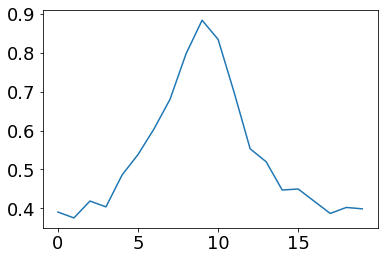

In [14]:
plt.plot(predicts)
plt.show()

In [15]:
# let us now look how the curve would look if we average it for many runs
k=40
predicts_averaging = np.zeros((k, D-1))
for j in tqdm(range(k)):
    
    models=[]
    for i in range(D-1):
        models.append(train_model(data_for_MLP(0,i+1,samples), 32, 100))
        
    with open('Models_for_XY/models_for_XY'+str(j)+'.pkl', 'wb') as f:
        pickle.dump(models, f)
    
    for i in range(D-1):
        predicts_averaging[j][i] = np.mean(models[i].predict(data_for_MLP(0,i+1,samples)[0][int(N):]))

100%|██████████| 40/40 [10:43:31<00:00, 965.29s/it]  


In [16]:
np.save('predicts_averaging.npy', predicts_averaging)

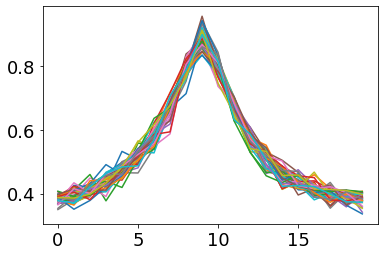

In [17]:
for i in range(k):
    plt.plot(predicts_averaging[i])

In [18]:
predicts_mean = np.mean(predicts_averaging, axis=0)
predicts_var  = np.std(predicts_averaging, axis=0)

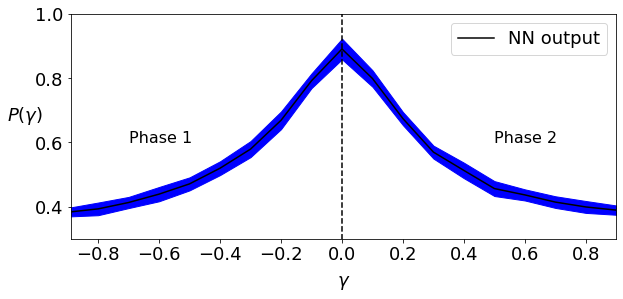

In [20]:
plt.figure(figsize=(9,4.5))
plt.text(-0.7, 0.6, 'Phase 1', fontsize=16)
plt.text(0.5 , 0.6, 'Phase 2', fontsize=16)
plt.fill_between(s[1:],predicts_mean-predicts_var, predicts_mean+predicts_var, color='blue')
plt.plot(s[1:], predicts_mean, c='black')
plt.xlim((-0.89,0.9))
plt.ylim((0.3,1))
plt.vlines(0,0,2, linestyles='dashed')
plt.xlabel('$\\gamma$', labelpad=10)
plt.ylabel('$P(\\gamma)$',rotation=0, labelpad=10)
plt.legend(['NN output'], fontsize=18)
plt.tight_layout() 
plt.savefig('XY_NN_Output.pdf', transparent=True)
plt.show()